# Lab IS&A
## Bagattin Enrico - Alessandro Doretto

In [1]:
# Import
import pandas as pd
import numpy as np
import glob

# Modules
from utilities import *
from dataPreparation import *

In [2]:
# Import data
years = [2017, 2018, 2019, 2020]
yearsForFeatures = [2016, 2017, 2018, 2019, 2020]
paths = []
for y in years:
    paths.append('matches/' + str(y) + '.xlsx') 
availablePaths = list(glob.glob("matches/20*.xlsx"))
matches = [pd.read_excel(path) for path in paths]
yearZeroForFeatures = pd.read_excel('matches/' + str(years[0]-1) + '.xlsx')
# TODO: Load matches based on number of past years choosen
df = pd.concat(matches, ignore_index=True, sort=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8254 entries, 0 to 8253
Data columns (total 40 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         8254 non-null   int64         
 1   Location    8254 non-null   object        
 2   Tournament  8254 non-null   object        
 3   Date        8254 non-null   datetime64[ns]
 4   Series      8254 non-null   object        
 5   Court       8254 non-null   object        
 6   Surface     8254 non-null   object        
 7   Round       8254 non-null   object        
 8   Best of     8254 non-null   int64         
 9   Winner      8254 non-null   object        
 10  Loser       8254 non-null   object        
 11  WRank       8250 non-null   float64       
 12  LRank       8230 non-null   float64       
 13  WPts        8251 non-null   float64       
 14  LPts        8230 non-null   float64       
 15  W1          8199 non-null   float64       
 16  L1          8201 non-nul

In [23]:
df.head().T

,0,1,2,3,4
ATP,1,1,1,1,1
Location,Brisbane,Brisbane,Brisbane,Brisbane,Brisbane
Tournament,Brisbane International,Brisbane International,Brisbane International,Brisbane International,Brisbane International
Date,2015-01-05 00:00:00,2015-01-05 00:00:00,2015-01-05 00:00:00,2015-01-05 00:00:00,2015-01-06 00:00:00
Series,ATP250,ATP250,ATP250,ATP250,ATP250
Court,Outdoor,Outdoor,Outdoor,Outdoor,Outdoor
Surface,Hard,Hard,Hard,Hard,Hard
Round,1st Round,1st Round,1st Round,1st Round,1st Round
Best of,3,3,3,3,3
Winner,Duckworth J.,Kokkinakis T.,Chardy J.,Tomic B.,Kukushkin M.


In [24]:
df.describe(include='all', percentiles=[]).T

,count,unique,top,freq,mean,std,min,50%,max,first,last
ATP,13510,NaN,NaN,NaN,32.6959,18.6616,1,33,67,NaT,NaT
Location,13510,78,Paris,870,NaN,NaN,NaN,NaN,NaN,NaT,NaT
Tournament,13510,93,Australian Open,762,NaN,NaN,NaN,NaN,NaN,NaT,NaT
Date,13510,1456,2020-01-21 00:00:00,51,NaN,NaN,NaN,NaN,NaN,2015-01-05,2020-02-16
Series,13510,5,ATP250,5637,NaN,NaN,NaN,NaN,NaN,NaT,NaT
Court,13510,2,Outdoor,11273,NaN,NaN,NaN,NaN,NaN,NaT,NaT
Surface,13510,3,Hard,7808,NaN,NaN,NaN,NaN,NaN,NaT,NaT
Round,13510,8,1st Round,6060,NaN,NaN,NaN,NaN,NaN,NaT,NaT
Best of,13510,NaN,NaN,NaN,3.39408,0.795554,3,3,5,NaT,NaT
Winner,13510,370,Djokovic N.,291,NaN,NaN,NaN,NaN,NaN,NaT,NaT


# Cleaning and preparing data

## Remove Winner/Loser reference
All the column with Winner/Loser reference will be substituted by Player0/Player1.

In [25]:
df = removeWinnerLoserReference(df)
yearZeroForFeatures = removeWinnerLoserReference(yearZeroForFeatures)

## Filling null:
* Rank: take the max rank plus one
* Pts: set default zero	
* Avg odd: take mode of matches with same (or similar) players rank
* B365, PS: fill with avg

In [26]:
rankDefault = max(df['Rank0'].max(), df['Rank1'].max())+1
df.fillna({'Rank0': rankDefault, 'Rank1': rankDefault, 'Pts0': 0, 'Pts1': 0}, inplace=True)

nullOddsDf = df[df[['B3650', 'B3651', 'PS0', 'PS1', 'Avg0', 'Avg1']].isna().any(axis=1)]
for index, row in nullOddsDf.iterrows():
    if pd.isnull(row['Avg0']) or pd.isnull(row['Avg1']):
        Avg0, Avg1 = findOddsForRow(row, df.dropna(subset=['Avg0', 'Avg1']))
        df.at[index, 'Avg0'] = row['Avg0'] = Avg0
        df.at[index, 'Avg1'] = row['Avg1'] = Avg1
    if pd.isnull(row['B3650']):
        df.at[index, 'B3650'] = row['Avg0']
    if pd.isnull(row['B3651']):
        df.at[index, 'B3651'] = row['Avg1']
    if pd.isnull(row['PS0']):
        df.at[index, 'PS0'] = row['Avg0']
    if pd.isnull(row['PS1']):
        df.at[index, 'PS1'] = row['Avg1']

df.dropna(subset=['Avg0', 'Avg1'], inplace=True) # Drop rows that hasn't similar rank matches
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13510 entries, 0 to 13509
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        13510 non-null  datetime64[ns]
 1   Location    13510 non-null  object        
 2   Tournament  13510 non-null  object        
 3   Series      13510 non-null  object        
 4   Court       13510 non-null  object        
 5   Surface     13510 non-null  object        
 6   Round       13510 non-null  object        
 7   Player0     13510 non-null  object        
 8   Player1     13510 non-null  object        
 9   Rank0       13510 non-null  float64       
 10  Rank1       13510 non-null  float64       
 11  Pts0        13510 non-null  float64       
 12  Pts1        13510 non-null  float64       
 13  Comment     13510 non-null  object        
 14  B3650       13510 non-null  float64       
 15  B3651       13510 non-null  float64       
 16  PS0         13510 non-

## New features
* [Elo rating](https://en.wikipedia.org/wiki/Elo_rating_system): a method for calculating the relative skill levels of players in zero-sum games
* Number of matches played during the last year
* Percentage of matches won during the last year
* Injuries: number matches in witch the player retired or walkover in the past year 
* Winning streak: current sequence of won games

In [27]:
X = addEloRatingFeature(df)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [28]:
X = addMatchesPlayedAndWonFeatures(X, yearZeroForFeatures, yearsForFeatures)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [29]:
X = addInjuriesAndWinningStreakFeatures(X, yearZeroForFeatures, yearsForFeatures)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [30]:
X.to_csv('generated/beforeDuplication.csv', index=False)

## Row duplication
To use both match outcomes for our prediction models we will duplicate each row. We can do it by switching all the player features for each duplicated row and adding a Winner column for the match result

In [31]:
X.columns

Index(['Date', 'Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round',
       'Player0', 'Player1', 'Rank0', 'Rank1', 'Pts0', 'Pts1', 'Comment',
       'B3650', 'B3651', 'PS0', 'PS1', 'Avg0', 'Avg1', 'EloRating0',
       'EloRating1', 'MatchesPlayed0', 'MatchesPlayed1', 'MatchesWon0',
       'MatchesWon1', 'Injuries0', 'Injuries1', 'WinningStreak0',
       'WinningStreak1'],
      dtype='object')

In [32]:
duplication = X.copy()
duplication.columns = ['Date', 'Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round',
       'Player1', 'Player0', 'Rank1', 'Rank0', 'Pts1', 'Pts0', 'Comment',
       'B3651', 'B3650', 'PS1', 'PS0', 'Avg1', 'Avg0', 'EloRating1',
       'EloRating0', 'MatchesPlayed1', 'MatchesPlayed0', 'MatchesWon1',
       'MatchesWon0', 'Injuries1', 'Injuries0', 'WinningStreak1',
       'WinningStreak0']

# Add the winner column
X = X.assign(Winner=np.zeros(X.shape[0])) # Player 0 always win
duplication = duplication.assign(Winner=np.ones(X.shape[0])) # Player 1 always win

X = pd.concat([X, duplication])
X.reset_index(inplace=True)
X.sort_values(by='index', inplace=True)
X.drop(columns=['Date', 'Comment', 'index'], inplace=True)

## One hot encoding
* Location
* Tournament
* Series
* Court
* Surface
* Round
* Players

In [33]:
X = pd.get_dummies(X)
print('Total number of columns:', len(X.columns))

X.to_csv('generated/finalDataset.csv', index=False)


Total number of columns: 1292


## Dataset subdivision: Train, Validation, Test

Train 60%, Validation 20%, Test 20% (taking as test the last part of the dataset)

In [3]:
import pandas as pd

X = pd.read_csv('generated/finalDataset.csv')

X.head()

,Rank0,Rank1,Pts0,Pts1,B3650,B3651,PS0,PS1,Avg0,Avg1,...,Player1_Zayid M.S.,Player1_Zeballos H.,Player1_Zekic M.,Player1_Zhang Ze,Player1_Zhang Ze.,Player1_Zhang Zh.,Player1_Zopp J.,Player1_Zverev A.,Player1_Zverev A.,Player1_Zverev M.
0,79.0,160.0,689.0,372.0,1.28,3.50,1.31,3.73,1.29,3.50,...,0,0,0,0,0,0,0,0,0,0
1,160.0,79.0,372.0,689.0,3.50,1.28,3.73,1.31,3.50,1.29,...,0,0,0,0,0,0,0,0,0,0
2,54.0,39.0,854.0,1102.0,2.50,1.50,2.52,1.58,2.43,1.54,...,0,0,0,0,0,0,0,0,0,0
3,39.0,54.0,1102.0,854.0,1.50,2.50,1.58,2.52,1.54,2.43,...,0,0,0,0,0,0,0,0,0,0
4,21.0,26.0,1785.0,1465.0,1.90,1.80,2.10,1.81,2.01,1.77,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.model_selection import train_test_split

y = X.Winner.values
X.drop(columns='Winner', inplace=True)

test_size = len(X)//5
X_test     = X[-test_size:]
y_test     = y[-test_size:]
X_train_80 = X[:-test_size]
y_train_80 = y[:-test_size]

# Random split for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_80, y_train_80, test_size=0.25, random_state=42)

# Remove duplicates from test
X_test = X_test.iloc[::2]
y_test = [x for i, x in enumerate(y_test) if i%2 == 0]

# Prediction models
We start by calculating how much powerful are the bookmakers' alghoritms, then we create and tune ours, let's see the results
## Baseline
Our first goal is to beat the average bookmaker accuracy

In [57]:
from sklearn.metrics import accuracy_score

# Player 1 wins if the odd is smaller than player 0
baseline = X_test['Avg1'] < X_test['Avg0']
baseline = baseline.astype(int)
baseline_test_acc = accuracy_score(y_true=y_test, y_pred=baseline)
print ("Test Accuracy: {:.2f}".format(baseline_test_acc*100), "%")

Test Accuracy: 68.56 %


In [5]:
accuraciesForModels = {'kNN': [], 'Naive Bayes': [], 'Decision Tree': [], 'Random Forest': []}

## k-Nearest-Neighbor Classifier

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
scaled_valid = scaler.transform(X_valid)
scaled_train_80 = scaler.transform(X_train_80)
scaled_test = scaler.transform(X_test)

In [25]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score

accuracies = []

for k in range(1,16):
    kNN = neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    kNN.fit(scaled_train, y_train)
    y_pred = kNN.predict(scaled_valid)
    valid_acc = accuracy_score(y_true=y_valid, y_pred=y_pred)
    print ("k: {:2d} | Validation Accuracy: {:.3f}".format(k, valid_acc))
    accuracies += [[valid_acc, k]]

k:  1 | Validation Accuracy: 0.519
k:  2 | Validation Accuracy: 0.531


KeyboardInterrupt: 

In [6]:
# All the resulting accuracies for a faster running process purpose

accuracies =   [[0.519, 1],
                [0.531, 2],
                [0.548, 3],
                [0.555, 4],
                [0.570, 5],
                [0.571, 6],
                [0.590, 7],
                [0.581, 8],
                [0.591, 9],
                [0.581, 10],
                [0.591, 11],
                [0.589, 12],
                [0.595, 13],
                [0.588, 14],
                [0.591, 15]]

accuraciesForModels['kNN'] = accuracies

In [11]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score

best_accuracy, best_k = max(accuracies)
print ( "Best K", best_k )

kNN = neighbors.KNeighborsClassifier(n_neighbors=best_k)
kNN.fit(scaled_train_80, y_train_80)

test_acc = accuracy_score(y_true=y_test, y_pred=kNN.predict(scaled_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

Best K 13
Test Accuracy: 0.578


## Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Train and predict
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Compute accuracy
train_acc = accuracy_score(y_true=y_train, y_pred=gnb.predict(X_train))
valid_acc = accuracy_score(y_true=y_valid, y_pred=gnb.predict(X_valid))
print ("Train Accuracy: {:.3f} - Validation Accuracy: {:.3f}".format(train_acc, valid_acc))

gnb.fit(X_train_80,y_train_80)

# Finally evaluate on test
test_acc = accuracy_score(y_true=y_test, y_pred=gnb.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

accuraciesForModels['Naive Bayes'] = [[valid_acc, 50]]

Train Accuracy: 0.684 - Validation Accuracy: 0.629
Test Accuracy: 0.630


## Decision Tree

In [47]:
from sklearn import tree
from sklearn.metrics import accuracy_score

accuracies = []

for max_leaves in range(2, 41, 2):
    # Train and predict
    dt = tree.DecisionTreeClassifier(max_leaf_nodes=max_leaves)
    dt.fit(X_train, y_train)

    # Compute accuracy
    train_acc = accuracy_score(y_true=y_train, y_pred=dt.predict(X_train))
    valid_acc = accuracy_score(y_true=y_valid, y_pred=dt.predict(X_valid))
    print ("Leaves: {:2d} - Train Accuracy: {:.3f} - Validation Accuracy: {:.3f}".format(
        max_leaves,  train_acc, valid_acc) )
    
    accuracies += [ [valid_acc, max_leaves] ]

best_accuracy, best_max_leaves = max(accuracies)
print ( "Best Max Leaves", best_max_leaves )

dt = tree.DecisionTreeClassifier(max_leaf_nodes=best_max_leaves)
dt.fit(X_train_80,y_train_80)

# Finally evaluate on test
test_acc = accuracy_score(y_true=y_test, y_pred=dt.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

accuraciesForModels['Decision Tree'] = accuracies

Leaves:  2 - Train Accuracy: 0.677 - Validation Accuracy: 0.684
Leaves:  4 - Train Accuracy: 0.677 - Validation Accuracy: 0.684
Leaves:  6 - Train Accuracy: 0.677 - Validation Accuracy: 0.684
Leaves:  8 - Train Accuracy: 0.677 - Validation Accuracy: 0.668
Leaves: 10 - Train Accuracy: 0.677 - Validation Accuracy: 0.668
Leaves: 12 - Train Accuracy: 0.678 - Validation Accuracy: 0.668
Leaves: 14 - Train Accuracy: 0.680 - Validation Accuracy: 0.667
Leaves: 16 - Train Accuracy: 0.680 - Validation Accuracy: 0.668
Leaves: 18 - Train Accuracy: 0.681 - Validation Accuracy: 0.668
Leaves: 20 - Train Accuracy: 0.681 - Validation Accuracy: 0.668
Leaves: 22 - Train Accuracy: 0.683 - Validation Accuracy: 0.668
Leaves: 24 - Train Accuracy: 0.685 - Validation Accuracy: 0.667
Leaves: 26 - Train Accuracy: 0.688 - Validation Accuracy: 0.674
Leaves: 28 - Train Accuracy: 0.688 - Validation Accuracy: 0.674
Leaves: 30 - Train Accuracy: 0.689 - Validation Accuracy: 0.675
Leaves: 32 - Train Accuracy: 0.689 - Val

## Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn import tree
from sklearn.metrics import accuracy_score

accuracies = []

for estimators in range(1, 150, 4):
    # Train a decision tree classifier
    rf = RandomForestClassifier(n_estimators=estimators, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Compute accuracy
    train_acc = accuracy_score(y_true=y_train, y_pred=rf.predict(X_train))
    valid_acc = accuracy_score(y_true=y_valid, y_pred=rf.predict(X_valid))
    print ("Number of Trees: {:3d} - Train Accuracy: {:.3f} - Validation Accuracy: {:.3f}".format(
        estimators,  train_acc, valid_acc) )
    
    accuracies += [ [valid_acc, estimators] ]

best_accuracy, best_estimators = max(accuracies)
print ( "Best Number of Trees", best_estimators )

rf = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1)
rf.fit(X_train_80,y_train_80)

# Finally evaluate on test
test_acc = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

accuraciesForModels['Random Forest'] = accuracies

Number of Trees:   1 - Train Accuracy: 0.850 - Validation Accuracy: 0.596
Number of Trees:   5 - Train Accuracy: 0.960 - Validation Accuracy: 0.638
Number of Trees:   9 - Train Accuracy: 0.985 - Validation Accuracy: 0.646
Number of Trees:  13 - Train Accuracy: 0.991 - Validation Accuracy: 0.647
Number of Trees:  17 - Train Accuracy: 0.995 - Validation Accuracy: 0.653
Number of Trees:  21 - Train Accuracy: 0.998 - Validation Accuracy: 0.656
Number of Trees:  25 - Train Accuracy: 0.998 - Validation Accuracy: 0.659
Number of Trees:  29 - Train Accuracy: 0.999 - Validation Accuracy: 0.661
Number of Trees:  33 - Train Accuracy: 0.999 - Validation Accuracy: 0.667
Number of Trees:  37 - Train Accuracy: 0.999 - Validation Accuracy: 0.672
Number of Trees:  41 - Train Accuracy: 1.000 - Validation Accuracy: 0.671
Number of Trees:  45 - Train Accuracy: 1.000 - Validation Accuracy: 0.669
Number of Trees:  49 - Train Accuracy: 1.000 - Validation Accuracy: 0.664
Number of Trees:  53 - Train Accuracy:

## Accuracy Results
Let's visualize all the results

In [22]:
cols = ['Model', 'Parameter', 'Accuracy']
accuraciesForPlots = pd.DataFrame(columns = cols)

for i, key in enumerate(accuraciesForModels):
    for el in accuraciesForModels[key]:
        accuraciesForPlots.loc[len(accuraciesForPlots)] = [key, el[1], el[0]]

accuraciesForPlots.head()

,Model,Parameter,Accuracy
0,kNN,1,0.519
1,kNN,2,0.531
2,kNN,3,0.548
3,kNN,4,0.555
4,kNN,5,0.570


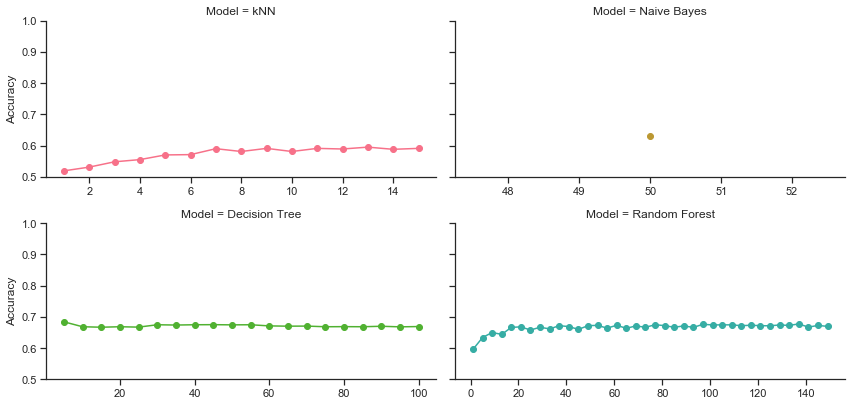

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")
sns.set_palette("husl")

grid = sns.FacetGrid(accuraciesForPlots, col="Model", aspect=2, ylim=(0.5, 1),
                     col_wrap=2, sharex=False, hue="Model")
grid.map(plt.axhline, y=0, ls=":", c=".5")
grid.map(plt.plot, 'Parameter', 'Accuracy', marker="o")
grid.set_axis_labels("", "Accuracy")

grid.savefig("generated/accuracies.png")

As we can see the kNN isn't very powerful with this type of predictions, the Naive Bayes model isn't bad but we can't tune it very much. So we will spend more effort with trying to increase the accuracy of the last two.

## Bias and Variance evaluation
We compute bias and variance by repeatedly training the models on different data samples.

### Decision Tree

Progress: |██████████████████████████████████████████████████| 100.0% Complete


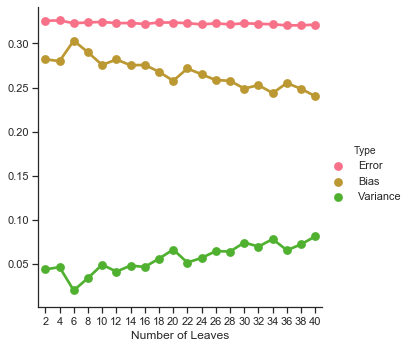

In [48]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
import numpy as np

N_TESTS = 20

stats = pd.DataFrame(columns=['Trees', 'Type', 'Value'])
printProgressBar(0, 40, prefix='Progress:', suffix='Complete')

for max_leaves in range(2, 41, 2):
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        dt = DecisionTreeClassifier(max_leaf_nodes=max_leaves)
        dt.fit(Xs,ys)

        y_pred = dt.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    dt_bias     = (y-np.mean(y_preds,axis=1))**2
    dt_variance = np.var(y_preds,axis=1)
    dt_error    = (y_preds - y.reshape(-1,1))**2

    stats.loc[len(stats)] = [max_leaves, 'Error', dt_error.mean()]
    stats.loc[len(stats)] = [max_leaves, 'Bias', dt_bias.mean()]
    stats.loc[len(stats)] = [max_leaves, 'Variance', dt_variance.mean()]
    
    printProgressBar(max_leaves, 40, prefix='Progress:', suffix='Complete')


grid = sns.catplot(x='Trees', y='Value', hue='Type', kind='point', data=stats)
grid.set_axis_labels("Number of Leaves", "")

grid.savefig("generated/bias-variance-DT.png")

As we can see from the results the variance seems to grow rapidly, so we can try to lower it using the bagging technique.

Progress: |██████████████████████████████████████████████████| 100.0% Complete


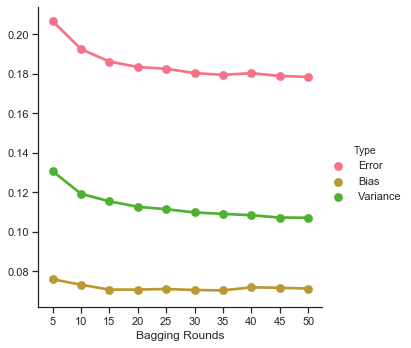

In [58]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import numpy as np

N_TESTS = 20

stats = pd.DataFrame(columns=['Trees', 'Type', 'Value'])
printProgressBar(0, 50, prefix='Progress:', suffix='Complete')

for b_rounds in range(5, 51, 5):
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X, y, n_samples=int(0.67*len(y)) )

        dt = BaggingClassifier(DecisionTreeClassifier(), n_estimators=b_rounds, n_jobs=-1)
        dt.fit(Xs,ys)

        y_pred = dt.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    dt_bias     = (y-np.mean(y_preds,axis=1))**2
    dt_variance = np.var(y_preds,axis=1)
    dt_error    = (y_preds - y.reshape(-1,1))**2

    stats.loc[len(stats)] = [b_rounds, 'Error', dt_error.mean()]
    stats.loc[len(stats)] = [b_rounds, 'Bias', dt_bias.mean()]
    stats.loc[len(stats)] = [b_rounds, 'Variance', dt_variance.mean()]
    
    printProgressBar(b_rounds, 50, prefix='Progress:', suffix='Complete')


grid = sns.catplot(x='Trees', y='Value', hue='Type', kind='point', data=stats)
grid.set_axis_labels("Bagging Rounds", "")

grid.savefig("generated/bias-variance-DT-bagging.png")

### Random Forest

Progress: |██████████████████████████████████████████████████| 100.0% Complete


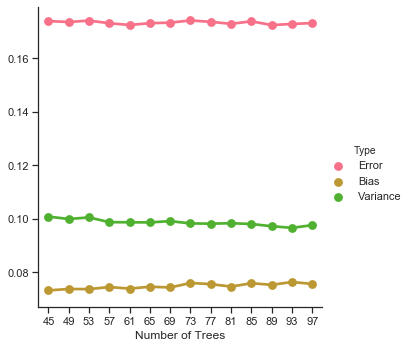

In [17]:
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
import numpy as np

N_TESTS = 20

stats = pd.DataFrame(columns=['Trees', 'Type', 'Value'])
printProgressBar(0, 97-45, prefix='Progress:', suffix='Complete')

for l in range(45, 100, 4):
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        rf = RandomForestClassifier(n_estimators=l, n_jobs=-1)
        rf.fit(Xs,ys)

        y_pred = rf.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    rf_bias     = (y-np.mean(y_preds,axis=1))**2
    rf_variance = np.var(y_preds,axis=1)
    rf_error    = (y_preds - y.reshape(-1,1))**2

    stats.loc[len(stats)] = [l, 'Error', rf_error.mean()]
    stats.loc[len(stats)] = [l, 'Bias', rf_bias.mean()]
    stats.loc[len(stats)] = [l, 'Variance', rf_variance.mean()]
    
    printProgressBar(l-45, 97-45, prefix='Progress:', suffix='Complete')


grid = sns.catplot(x='Trees', y='Value', hue='Type', kind='point', data=stats)
grid.set_axis_labels("Number of Trees", "")

grid.savefig("generated/bias-variance-RF.png")

## Further improvements: Ensemble methods and Hyperparameters

To improve Decision Tree we will try to apply the bagging technique to see the improvements that we have found with bias/variance analysis. For Random Forest we have found a pretty stable error "curve", we will proceed with the use of more hyperparameters.

### Bagging applied to Decision Tree

In [63]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

accuracies = []

for b_rounds in range(60, 81, 5):
    dt = BaggingClassifier(DecisionTreeClassifier(), n_estimators=b_rounds, n_jobs=-1)
    dt.fit(X_train, y_train)

    train_acc = accuracy_score(y_true=y_train, y_pred=dt.predict(X_train))
    valid_acc = accuracy_score(y_true=y_valid, y_pred=dt.predict(X_valid))
    print ("Bagging Rounds: {:2d} - Train Accuracy: {:.3f} - Validation Accuracy: {:.3f}".format(
        b_rounds,  train_acc, valid_acc) )
    
    accuracies += [ [valid_acc, b_rounds] ]

best_accuracy, best_b_rounds = max(accuracies)
print ( "Best Max Leaves", best_b_rounds )

dt = BaggingClassifier(DecisionTreeClassifier(max_leaf_nodes=5), n_estimators=75, n_jobs=-1)
dt.fit(X_train_80,y_train_80)
test_acc = accuracy_score(y_true=y_test, y_pred=dt.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

Bagging Rounds: 60 - Train Accuracy: 1.000 - Validation Accuracy: 0.661
Bagging Rounds: 65 - Train Accuracy: 1.000 - Validation Accuracy: 0.664
Bagging Rounds: 70 - Train Accuracy: 1.000 - Validation Accuracy: 0.667
Bagging Rounds: 75 - Train Accuracy: 1.000 - Validation Accuracy: 0.664
Bagging Rounds: 80 - Train Accuracy: 1.000 - Validation Accuracy: 0.666
Best Max Leaves 70
Test Accuracy: 0.679


### Fine tuning Random Forest with Randomized Search

Now we will try to tune the random forest to see if we can get better results

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [37]:
from sklearn.model_selection import RandomizedSearchCV

# Number of features to consider at every split
max_features = ['auto', 'log2']

# Maximum number of leaf in tree
max_leaf_nodes = [int(x) for x in np.linspace(5, 100, num = 10)]
max_leaf_nodes.append(None)

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 150, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 4, 8, 16]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]

# Create the random grid
random_grid = {
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

In [39]:
rf = RandomForestClassifier(n_estimators=97)
# Random search of parameters 
# Default 5-fold cross validation, 50 different combinations, and use all available CPU cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter = 50, random_state=42, n_jobs = -1, verbose=2)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.4min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [40]:
rf_random.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_features': 'auto',
 'max_depth': 136}

Resulted in:

```
{ 'min_samples_split': 2,
  'min_samples_leaf': 8,
  'max_features': 'auto',
  'max_depth': 136 }
```

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=97, min_samples_split=2, min_samples_leaf=8, max_depth=136)
rf.fit(X_train, y_train)

train_acc = accuracy_score(y_true=y_train, y_pred=rf.predict(X_train))
print ("Train Accuracy: {:.3f}".format(train_acc))

valid_acc = accuracy_score(y_true=y_valid, y_pred=rf.predict(X_valid))
print ("Validation Accuracy: {:.3f}".format(valid_acc))

rf.fit(X_train_80,y_train_80)
test_acc = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

Train Accuracy: 0.681
Validation Accuracy: 0.682
Test Accuracy: 0.682


Our previous RF: Train Accuracy: 1.000 - Validation Accuracy: 0.677 - Test accuracy: 0.661

The tuned one: Train Accuracy: 0.724 - Validation Accuracy: 0.678 - Test Accuracy: 0.678
  
We've got a good gain of 1.7 % on the final test accuracy. Also we have improved the validation accuracy with respect to Bagged Decision Tree (0.667) by 1.2 %.

### Fine tuning Random Forest with Grid Research

Now we have a general idea of what are the best parameters intervals, we will use Grid Research to improve more our params.

In [42]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [134, 135, 136, 137, 138],
    'min_samples_leaf': [6, 7, 8, 9, 10],
    'min_samples_split': [1, 2, 3, 4]
}

rf = RandomForestClassifier(n_estimators=97)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=97, n_jobs=None,
                                              oob_score=False,
                                              ran

In [43]:
grid_search.best_params_

{'max_depth': 138, 'min_samples_leaf': 9, 'min_samples_split': 2}

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=97, min_samples_split=2, min_samples_leaf=9, max_depth=138)
rf.fit(X_train, y_train)

train_acc = accuracy_score(y_true=y_train, y_pred=rf.predict(X_train))
print ("Train Accuracy: {:.3f}".format(train_acc))

valid_acc = accuracy_score(y_true=y_valid, y_pred=rf.predict(X_valid))
print ("Validation Accuracy: {:.3f}".format(valid_acc))

rf.fit(X_train_80,y_train_80)
test_acc = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

Train Accuracy: 0.718
Validation Accuracy: 0.683
Test Accuracy: 0.670


There isn't improvement on the results, so we conclude to have reached the maximum potential of the classifier with the previous parameters. We can move on a new analysis.

## Feature Analysis

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=97, min_samples_split=2, min_samples_leaf=8, max_depth=136)
rf.fit(X_train_80, y_train_80)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=136, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=97,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
featureImportance = pd.DataFrame()
featureImportance['Feature'] = X.columns
featureImportance['Importance'] = rf.feature_importances_

plotFeatures = featureImportance.sort_values(by='Importance', ascending=False).head(n=30)

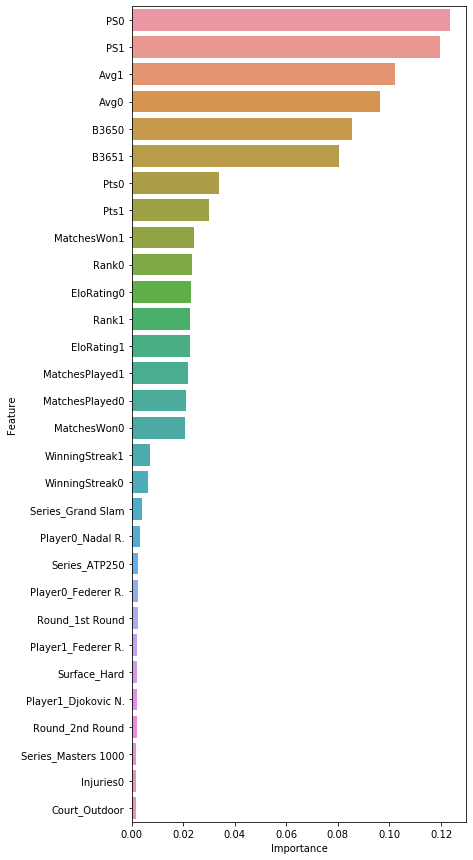

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(6, 15))

sns.barplot(x="Importance", y="Feature", data=plotFeatures)

f.savefig("generated/RF-feature-importance.png")

### Recursive Feature Elimination

In [13]:
from sklearn.feature_selection import RFE

selector = RFE(rf, step=100, n_features_to_select=5)

selector.fit(X,y)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=136, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=8, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=97, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=5, step=100, verbose=0)

In [14]:
selector.ranking_

array([ 2,  2,  2, ...,  3, 12,  4])

In [15]:
featureImportance['Rank'] = selector.ranking_
plotRank = featureImportance.sort_values(by='Rank').head(n=80)

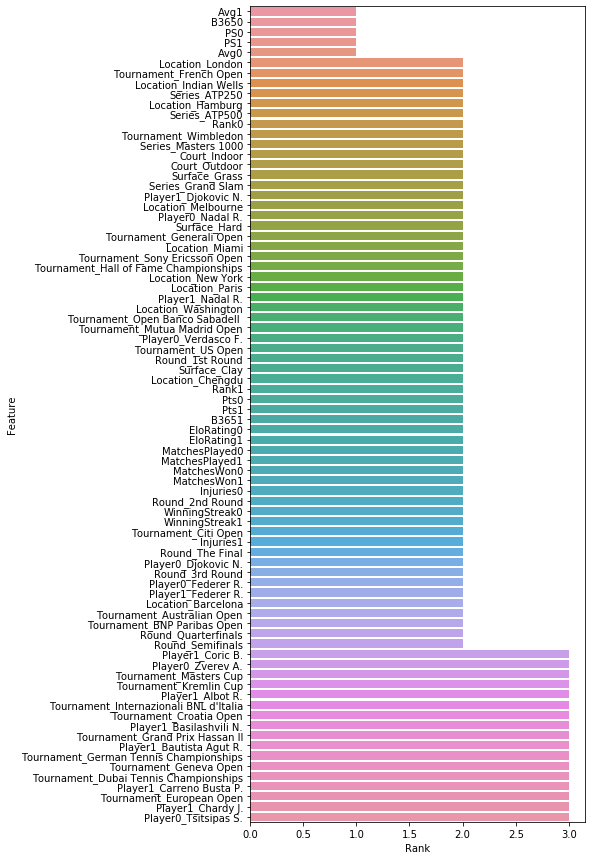

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(6, 15))

sns.barplot(x="Rank", y="Feature", data=plotRank)
f.savefig("generated/RFE-features-ranking.png")

As we can see from the two plots the most important features are very similar, we can try to remove all the players columns to see if the accuracy increases

0.6723198061780739


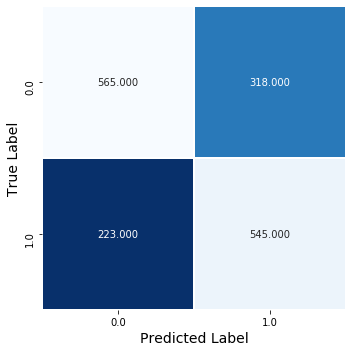

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=52)
rf.fit(X_train_80, y_train_80)
predicted = rf.predict(X_test)
conf_stat = confusion_matrix(y_true=y_test, y_pred=predicted)

print(accuracy_score(y_true=y_test, y_pred=predicted))

import seaborn as sns

fig, ax = plt.subplots(figsize=(5,5), tight_layout=True)
sns.heatmap(conf_stat, annot=True, fmt=".3f", 
            linewidths=.5, square = True, 
            cmap = 'Blues_r',cbar=False,
            xticklabels=rf.classes_,
            yticklabels=rf.classes_);
ax.set_ylabel('True Label', fontsize=14);
ax.set_xlabel('Predicted Label', fontsize=14);

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

accuracies = []

for i in range(1, 13):
    columns = featureImportance[featureImportance['Rank'] <= i]['Feature']

    X_test_red = X_test[columns]
    X_train_80_red = X_train_80[columns]
    X_train_red = X_train[columns]
    X_valid_red = X_valid[columns]

    rf = RandomForestClassifier(n_estimators=97, min_samples_split=2, min_samples_leaf=8, max_depth=136)
    rf.fit(X_train_red, y_train)
    predicted = accuracy_score(y_true=y_valid, y_pred=rf.predict(X_valid_red))
    accuracies += [ [predicted, i] ]
    print('Features Rank', i, 'Accuracy on validation: ', predicted)

Features Rank 1 Accuracy on validation:  0.6665657177468202
Features Rank 2 Accuracy on validation:  0.6729254996971532
Features Rank 3 Accuracy on validation:  0.6671714112658994
Features Rank 4 Accuracy on validation:  0.678679588128407
Features Rank 5 Accuracy on validation:  0.6692913385826772
Features Rank 6 Accuracy on validation:  0.6753482737734706
Features Rank 7 Accuracy on validation:  0.6732283464566929
Features Rank 8 Accuracy on validation:  0.6801938219261053
Features Rank 9 Accuracy on validation:  0.677771047849788
Features Rank 10 Accuracy on validation:  0.6783767413688674
Features Rank 11 Accuracy on validation:  0.6756511205330104
Features Rank 12 Accuracy on validation:  0.677771047849788


Best Rank 8
Test Accuracy: 0.674


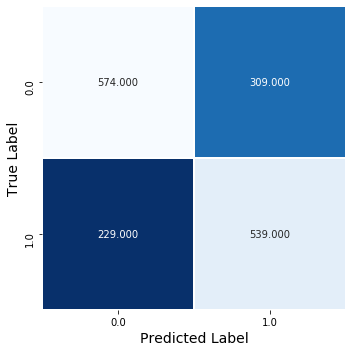

In [19]:
best_accuracy, best_rank = max(accuracies)
print ( "Best Rank", best_rank )

columns = featureImportance[featureImportance['Rank'] <= best_rank]['Feature']

X_test_red = X_test[columns]
X_train_80_red = X_train_80[columns]
X_train_red = X_train[columns]
X_valid_red = X_valid[columns]

rf = RandomForestClassifier(n_estimators=97, min_samples_split=2, min_samples_leaf=8, max_depth=136)
rf.fit(X_train_80_red,y_train_80)

predicted = rf.predict(X_test_red)
test_acc = accuracy_score(y_true=y_test, y_pred=predicted)
print ("Test Accuracy: {:.3f}".format(test_acc))

conf_stat = confusion_matrix(y_true=y_test, y_pred=predicted)

import seaborn as sns

fig, ax = plt.subplots(figsize=(5,5), tight_layout=True)
sns.heatmap(conf_stat, annot=True, fmt=".3f", 
            linewidths=.5, square = True, 
            cmap = 'Blues_r',cbar=False,
            xticklabels=rf.classes_,
            yticklabels=rf.classes_);
ax.set_ylabel('True Label', fontsize=14);
ax.set_xlabel('Predicted Label', fontsize=14);

After removing part of the features we can see a little improvement!

### Clustering
Now we have maximized our classifier accuracy, we move on with clustering. The main purpose is to see if we can determine where our classifier works the best and isolate those cases to bulid a low risk betting strategy.

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=97, min_samples_split=2, min_samples_leaf=8, max_depth=136)
rf.fit(X_train_red, y_train)
predicted = rf.predict(X_valid_red)

In [21]:
# Apply XOR to find wrongly predicted matches
import numpy as np

wrong_predictions_mask = np.logical_xor(y_valid, predicted)
right_predictions_mask = np.logical_not(np.logical_xor(y_valid, predicted))

wrong_predictions = X_valid_red[wrong_predictions_mask]
right_predictions = X_valid_red[right_predictions_mask]

wrong_predictions.head()

,Rank0,Rank1,Pts0,Pts1,B3650,B3651,PS0,PS1,Avg0,Avg1,...,Player1_Zapata Miralles B.,Player1_Zayid M.S.,Player1_Zeballos H.,Player1_Zekic M.,Player1_Zhang Ze,Player1_Zhang Ze.,Player1_Zhang Zh.,Player1_Zopp J.,Player1_Zverev A.,Player1_Zverev M.
7677,66.0,97.0,835.0,626.0,1.22,4.00,1.22,4.70,1.22,4.29,...,0,0,0,0,0,0,0,0,0,0
8369,44.0,31.0,1070.0,1465.0,2.50,1.53,2.71,1.53,2.57,1.51,...,0,0,0,0,0,0,0,0,0,0
10224,49.0,217.0,1030.0,255.0,1.72,2.10,1.77,2.20,1.75,2.11,...,0,0,0,0,0,0,0,0,0,0
7235,55.0,92.0,951.0,664.0,1.61,2.30,1.71,2.29,1.65,2.26,...,0,0,0,0,0,0,0,0,0,0
11817,52.0,84.0,920.0,663.0,1.72,2.00,1.87,2.04,1.81,2.01,...,0,0,0,0,0,0,0,0,0,0


In [22]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def plotClusters (feature):
    dbscan = DBSCAN()
    labelsR = dbscan.fit_predict(right_predictions[feature])
    labelsW = dbscan.fit_predict(wrong_predictions[feature])

    fig, axs = plt.subplots(ncols=2, figsize=(12,5))

    axs[0].scatter(right_predictions[feature[0]], right_predictions[feature[1]], c=labelsR)
    axs[0].set_title("Right Predictions " + feature[0])

    axs[1].scatter(wrong_predictions[feature[0]], wrong_predictions[feature[1]], c=labelsW)
    axs[1].set_title("Wrong Predictions " + feature[0])

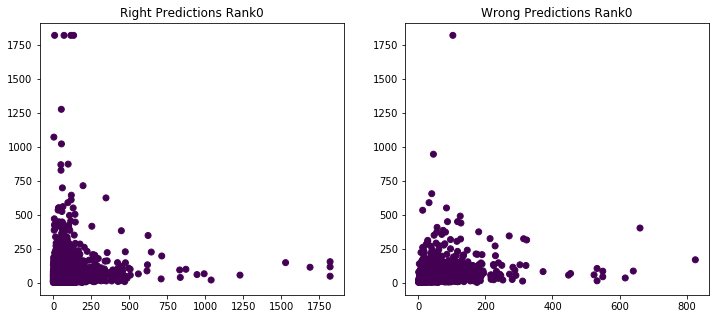

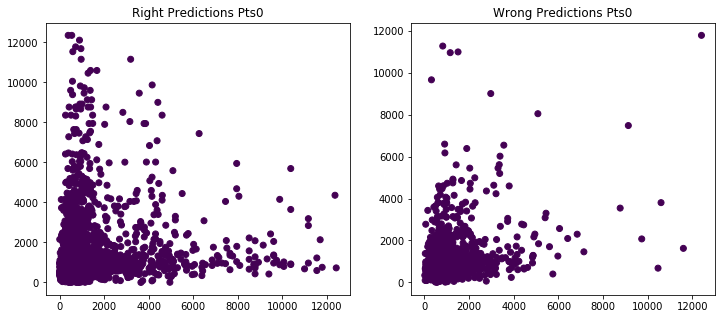

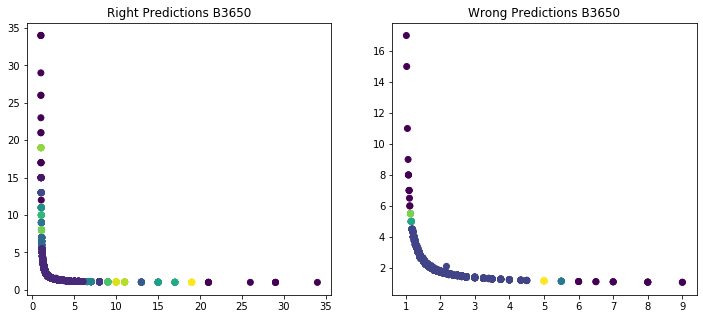

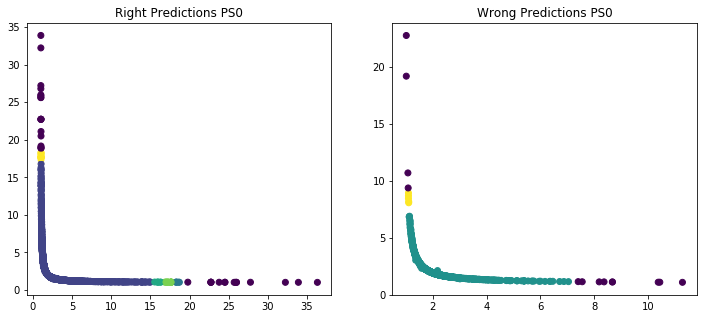

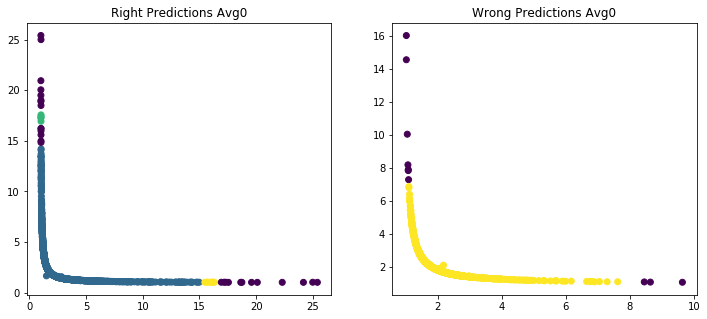

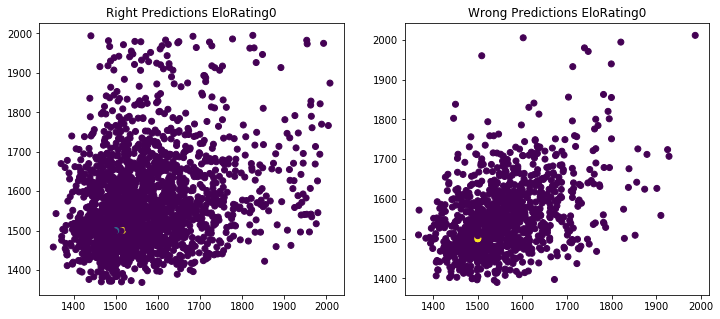

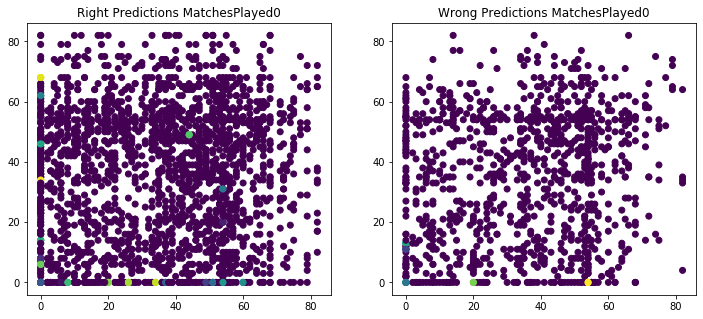

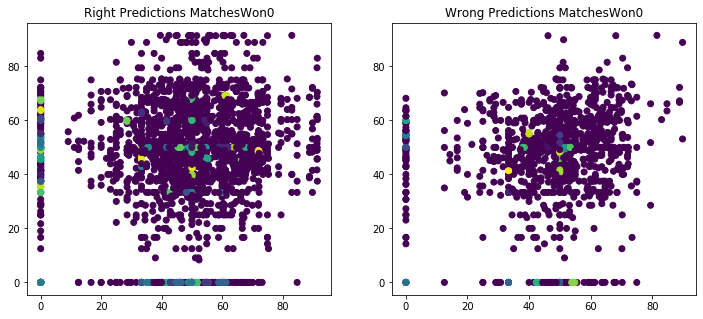

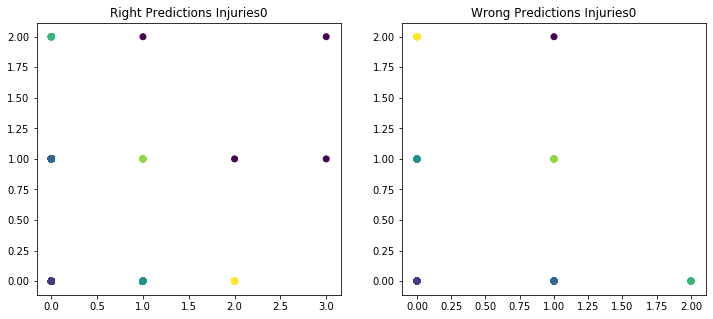

In [23]:
features = [['Rank0', 'Rank1'],
            ['Pts0', 'Pts1'],
            ['B3650', 'B3651'],
            ['PS0', 'PS1'],
            ['Avg0', 'Avg1'],
            ['EloRating0', 'EloRating1'],
            ['MatchesPlayed0', 'MatchesPlayed1'],
            ['MatchesWon0', 'MatchesWon1'],
            ['Injuries0', 'Injuries1']]

for feature in features:
    plotClusters(feature)

Clustering seems to be useless. Even if we tune parameters the data distributions between right and wrong predictions are very similar, so we couldn't find some independent cluster to work on for improving our strategy.

# Betting Strategy
Now that we have maximaized our prediction accuracy, we study a way to have a great ability to find good matches to bet on and simulate the results of the strategy.

## Baseline
Let's start by putting a "baseline" also for the strategy. Our strategy will be: bet always on the smaller odd player

In [203]:
def roiCalculation (odd, win=True):
    return (odd-1) if win else -1

test_data = X_test[['Rank1', 'Rank0', 'Avg1', 'Avg0']]
test_data = test_data.assign(Winner = y_test)

validation_for_classifier = X_valid_red.iloc[::2]
valid_data = validation_for_classifier[['Rank1', 'Rank0', 'Avg1', 'Avg0']]
valid_data = valid_data.assign(Winner = [x for i, x in enumerate(y_valid) if i%2 == 0])

valid_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

test_data.head()

,Rank1,Rank0,Avg1,Avg0,Winner
0,32.0,122.0,1.56,2.45,1.0
1,138.0,62.0,1.91,1.89,0.0
2,64.0,67.0,2.25,1.63,0.0
3,35.0,71.0,1.40,2.93,1.0
4,42.0,93.0,1.35,3.17,1.0


In [204]:
predicted = np.zeros(len(test_data))
roi = np.zeros(len(test_data))

# Betting an all matches using the bookmaker probability (inverse of odds)
for i, row in test_data.iterrows():
    predicted[i] = row['Avg1'] < row['Avg0']
    roi[i] = roiCalculation(row['Avg' + str(int(row['Winner']))]) if predicted[i].astype(int) == row['Winner'] else -1
    i += 1

test_data = test_data.assign(Predicted = predicted, Roi = roi)

final_roi = test_data.Roi.mean()
print("Final ROI: {:.2f} %".format(final_roi * 100))

Final ROI: -1.87 %


To be more practical: investing on each match 1€, we will finish with a 30€ lost (1651€ invested)

## Our strategy
Now we will try to use our classificator with some parameters: the probability assigned for that prediction and the minimum odd (very low odd, like 1.1 could lower our ROI, because the gain is very low compared to the loss)

In [209]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=97, min_samples_split=2, min_samples_leaf=8, max_depth=136, random_state = 42)
rf.fit(X_train_80_red, y_train_80)
predicted = rf.predict(X_test_red)
predictedProb = rf.predict_proba(X_test_red)

test_data = test_data.assign(Proba = np.zeros(len(test_data)))
test_data = test_data.assign(Predicted = predicted, Proba = predictedProb)

rf_for_valid = RandomForestClassifier(n_estimators=97, min_samples_split=2, min_samples_leaf=8, max_depth=136, random_state = 42)
rf_for_valid.fit(X_train_red, y_train)
predicted_for_valid = rf_for_valid.predict(validation_for_classifier)
predictedProb_for_valid = rf_for_valid.predict_proba(validation_for_classifier)

valid_data = valid_data.assign(Proba = np.zeros(len(valid_data)))
valid_data = valid_data.assign(Predicted = predicted_for_valid, Proba = predictedProb_for_valid)


In [225]:
def calc_roi(data, probability, min_odd, print_res=False):
    data = data[data.Proba > probability]
    data.reset_index(drop=True, inplace=True)
    roi = np.zeros(len(data))

    for i, row in data.iterrows():
        if(row['Avg' + str(int(row['Predicted']))] >= min_odd):
            roi[i] = roiCalculation(row['Avg' + str(int(row['Winner']))]) if row['Predicted'] == row['Winner'] else -1
        else:
            roi[i] = 0

    data = data.assign(Roi = roi)
    final_roi = data[data.Roi != 0].Roi.mean()
    if print_res:
        print("Final ROI: {:.2f} %".format(final_roi * 100), "Number of bets:", len(data[data.Roi != 0]))
    else:
        return final_roi, len(data[data.Roi != 0])

rois = pd.DataFrame(columns=['Probability', 'MinOdd', 'ROI', 'nBets'])

for i in range(1, 10):
    for j in range(1, 28):
        roi, nBets = calc_roi(valid_data, i/10, j/10)
        rois.loc[len(rois)] = [i/10, j/10, roi, nBets]

rois.sort_values(by='ROI', inplace=True, ascending=False)
rois[pd.notna(rois.ROI)]

,Probability,MinOdd,ROI,nBets
51,0.2,2.5,1.51,1.0
78,0.3,2.5,1.51,1.0
105,0.4,2.5,1.51,1.0
24,0.1,2.5,1.51,1.0
129,0.5,2.2,0.91,6.0
...,...,...,...,...
238,0.9,2.3,NaN,0.0
239,0.9,2.4,NaN,0.0
240,0.9,2.5,NaN,0.0
241,0.9,2.6,NaN,0.0


In [237]:
rois[(pd.notna(rois.ROI)) & (rois.nBets > 10)]

,Probability,MinOdd,ROI,nBets
48,0.2,2.2,0.753333,12.0
21,0.1,2.2,0.753333,12.0
102,0.4,2.2,0.753333,12.0
75,0.3,2.2,0.753333,12.0
127,0.5,2.0,0.508235,17.0
...,...,...,...,...
172,0.7,1.1,-0.085781,256.0
173,0.7,1.2,-0.095642,179.0
149,0.6,1.5,-0.102727,66.0
150,0.6,1.6,-0.142381,21.0


In [ ]:
labels=["very interested","somewhat interested", 
        "only a little interested", "not at all interested"]
# Create new dataframe column with the labels instead of numbers
df["Interested in politics"] = df["interest"].map(dict(zip(range(1,5), labels)))

plt.figure(figsize=(10,8))
# Use newly created dataframe column as hue
ax = sns.barplot(data=df, x='reads', estimator=len,y='interest', 
                 hue='Interested in politics', hue_order=labels)
ax.set_ylabel("Sample Size")

plt.show()